# Recomendador de inversiones inmoviliarias

## Datos origen:

- [indicadores](datasets/gem_indicadores.csv)
- [pisos](datasets/idealista_datafile.csv)


## Tareas:

1. Asignar precio estadístico de alquiler y compraventa a cada inmueble basado en su barrio o distrito
1. Crear una puntuación para el precio de compra para cada inmueble de 0 a 1 en función del precio estadístico de compra de cada barrio o distrito
1. Crear una puntuación para el precio de alquiler para cada inmueble de 0 a 1 en función del precio estadístico de alquiler de cada barrio o distrito
1. Calcular la tasa de retorno de cada inmueble en función del precio de compra y el precio de alquiler
1. Crear una puntuación final para cada inmueble de 0 a 1 en función de las puntuaciones anteriores


In [48]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import warnings
warnings.filterwarnings('ignore')

pisos = pd.read_csv('datasets/idealista_datafile.csv')
indicadores = pd.read_csv('datasets/gen_indicadores.csv')

# convertir los campos price y price_old a enteros, interpretando el punto como separador de miles
pisos[['price','price_old']] = (pisos[['price','price_old']].fillna(0)).astype(int).replace(0, np.nan)


display(pisos.info())
display(indicadores)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   link         281 non-null    object 
 1   type_v       281 non-null    object 
 2   address      281 non-null    object 
 3   town         281 non-null    object 
 4   price        281 non-null    int64  
 5   price_old    15 non-null     float64
 6   info         281 non-null    object 
 7   description  281 non-null    object 
 8   tags         16 non-null     object 
 9   agent        0 non-null      float64
 10  created      281 non-null    object 
dtypes: float64(2), int64(1), object(8)
memory usage: 24.3+ KB


None

,id,nombre,sup_id,sup_nombre,tipo,precio_venta_1y,superficie_venta_1y,elasticidad_1y,precio_alquiler_1y,rentabilidad_1y,...,grow_acu_alquiler_1y_stars,grow_acu_venta_1y_stars,elasticidad_5y_stars,rentabilidad_5y_stars,grow_acu_alquiler_5y_stars,grow_acu_venta_5y_stars,elasticidad_10y_stars,rentabilidad_10y_stars,grow_acu_alquiler_10y_stars,grow_acu_venta_10y_stars
0,80101,el raval,80100,ciutat vella,barri,3007.6667,11779.0000,-inf,15.840,0.0632,...,2,4,2,3,1,4,3,2,2,3
1,80102,el barri gotic,80100,ciutat vella,barri,4558.7500,9567.3333,0.0257,15.735,0.0414,...,3,4,1,1,1,1,2,1,1,1
2,80103,la barceloneta,80100,ciutat vella,barri,4195.7500,1533.5000,-0.1123,20.835,0.0596,...,2,2,1,2,1,2,2,2,1,2
3,80104,"sant pere, santa caterina i la ribera",80100,ciutat vella,barri,4152.8889,3002.8000,-0.0270,17.635,0.0510,...,2,4,1,2,2,4,2,1,3,2
4,80205,el fort pienc,80200,eixample,barri,4162.8889,2202.7500,0.0935,15.840,0.0457,...,2,4,1,2,1,3,2,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,80700,horta guinardo,80000,barcelona,districte,3185.2222,12270.5000,0.7296,14.600,0.0550,...,1,2,3,4,3,5,1,4,3,4
80,80800,nou barris,80000,barcelona,districte,2467.7778,26275.7500,0.0299,13.160,0.0640,...,3,1,2,5,5,3,2,5,5,5
81,80900,sant andreu,80000,barcelona,districte,2937.8889,5897.5000,-0.1689,13.840,0.0565,...,5,2,1,3,5,3,3,4,5,1
82,81000,sant marti,80000,barcelona,districte,3607.0000,17390.0000,0.6658,16.500,0.0549,...,3,2,1,3,3,4,5,3,4,1


In [49]:
import re
# Estandarizar nombres de distriros para facilitar la convinación de campos

import unicodedata
import html

def estandarizar(x):
    """ Estandariza el nombre de un barrio o distrito:
         - Quita entidades HTML y UTF-8
         - Normaliza el texto a forma NFD (descompone caracteres con diacríticos)
         - Filtra caracteres con categoría de diacrítico (Mn)
         - Pasa a minúsculas
         - Reemplaza guiones por espacios
         - Quita espacios dobles
    """
    # Unescape HTML and UTF-8 entities
    x = html.unescape(x)
    # Normalizar el texto a forma NFD (descompone caracteres con diacríticos)
    x = unicodedata.normalize('NFD', x)
    # Filtrar caracteres con categoría de diacrítico (Mn)
    x = ''.join(c for c in x if unicodedata.category(c) != 'Mn')
    return x.split(' - AEI ')[0].replace('-', ' ').replace('  ', ' ').lower()


hab_rx = re.compile(r'\'(\d+?) hab\.\'')
m2_rx = re.compile(r'\'(\d+?) m²\'')
barrio_rx = re.compile(r"([^,]+),[^,]+$")

def get_hood(x):
    x1 = ''.join(barrio_rx.findall(x)).strip() 
    x1 = x1 if len(x1)>1 else x
    return estandarizar(x1)

pisos['town'] = pisos['town'].map(get_hood)
pisos['description'] = pisos['description'].map(lambda x: re.sub(r"<.*?>", "", x))
pisos[['type_v','address', 'description']] = pisos[['type_v','address', 'description']].applymap(estandarizar)
pisos['n_hab'] = pisos['info'].map(lambda x: int(''.join(hab_rx.findall(x))) if hab_rx.findall(x) else None).astype('Int64')
pisos['sup_m2'] = pisos['info'].map(lambda x: int(''.join(m2_rx.findall(x))) if m2_rx.findall(x) else None).astype('Int64')


pisos



,link,type_v,address,town,price,price_old,info,description,tags,agent,created,n_hab,sup_m2
0,https://www.idealista.com/inmueble/106924638/,piso,"calle de l'om, el raval, barcelona",el raval,100000,NaN,"['3 hab.', '50 m²', 'Entreplanta exterior sin ...",piso de 50 m2 en calle om totalmente a reforma...,NaN,NaN,2025-01-01 12:43:17,3,50
1,https://www.idealista.com/inmueble/106923754/,piso,"calle de l'om, el raval, barcelona",el raval,100000,NaN,"['3 hab.', '49 m²', 'Entreplanta exterior sin ...","piso de 49m² en venta en calle om, en ciutat v...",NaN,NaN,2025-01-01 12:43:17,3,49
2,https://www.idealista.com/inmueble/106910818/,estudio,"calle de muntaner, sant antoni, barcelona",sant antoni,100000,NaN,"['17 m²', 'Planta 4ª exterior con ascensor']",vivienda en un solo ambiente tipo loft! tranqu...,NaN,NaN,2025-01-01 12:43:17,<NA>,17
3,https://www.idealista.com/inmueble/104891324/,piso,"calle de les carretes, el raval, barcelona",el raval,92000,NaN,"['1 hab.', '44 m²', 'Planta 1ª sin ascensor']",oportunidad solo para inversores. debido al es...,NaN,NaN,2025-01-01 12:43:17,1,44
4,https://www.idealista.com/inmueble/106912666/,piso,"la trinitat nova, barcelona",la trinitat nova,66660,NaN,"['2 hab.', '49 m²', ' exterior sin ascensor']",no cobramos comision al comprador. inmueble oc...,NaN,NaN,2025-01-01 12:43:17,2,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,https://www.idealista.com/inmueble/101539089/,estudio,"calle de duran i borrell, el coll, barcelona",el coll,75000,NaN,"['30 m²', 'Planta 1ª interior sin ascensor']",importante:•estudio con cedula!•finca afectada...,NaN,NaN,2025-01-01 12:43:56,<NA>,30
277,https://www.idealista.com/inmueble/101240861/,estudio,"calle de catania, el besos, barcelona",el besos,82000,NaN,['48 m²'],¡oportunidad para comprar tu piso! situado en ...,NaN,NaN,2025-01-01 12:43:56,<NA>,48
278,https://www.idealista.com/inmueble/97594414/,estudio,"serra, el gotic, barcelona",el gotic,85000,NaN,"['26 m²', 'Bajo interior sin ascensor']",excelente estudio reformado en pleno barrio go...,NaN,NaN,2025-01-01 12:43:56,<NA>,26
279,https://www.idealista.com/inmueble/88456465/,piso,"calle de la reina amalia, el raval, barcelona",el raval,89000,NaN,"['2 hab.', '46 m²', ' sin ascensor']",¿quieres comprar piso de 2 habitaciones en bar...,NaN,NaN,2025-01-01 12:43:56,2,46


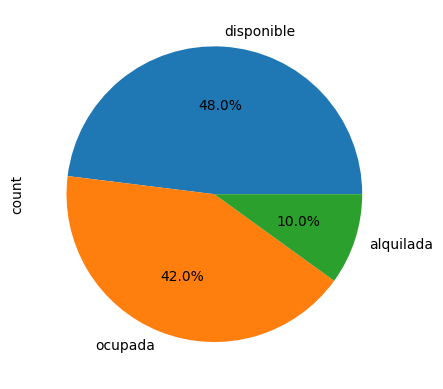

    disponibilidad                                                                                                                                                                                                                                                                                                                                                             description
0       disponible                                                                                                                                                                                                                           piso de 50 m2 en calle om totalmente a reformar.finca de 1840 sin ascensor.dispone de salon, 3 habitaciones, cocina y 1 bano. suelos de gres.
1       disponible                                                   piso de 49m² en venta en calle om, en ciutat vella.primera planta real en finca sin ascensor.piso exterior con balcon.tiene 3 habitaciones, cocina y salon comedor.precisa de

In [50]:
okupadas_words = ['okupada', 'okupado', 'ocupado', 'ocupada', 'ocupacional', 'sin posesión', 'sin posesion','ilegal']
alquiladas_words = ['alquilado', 'alquilada', 'inquilinos', 'inquilino', 'usufructuarios', 'usufructuario','arrendado']
def get_occupation(x):
    if any(word.lower() in x.lower() for word in okupadas_words): return 'ocupada'
    if any(word.lower() in x.lower() for word in alquiladas_words): return 'alquilada'
    return 'disponible'

pisos['disponibilidad'] = pisos['description'].map(get_occupation)


pisos['disponibilidad'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()
print(pisos[pisos['disponibilidad'] == 'disponible'][['disponibilidad','description']].to_string())


In [51]:
# Preprocesamiento básico para asegurar que no haya valores nulos en el campo 'description'
pisos['description'] = pisos['description'].fillna("")

# Lista de palabras clave para el análisis inmobiliario
single_keywords = [
    "inversi.n", "oportunidad" , "rendimiento", "renta.ilidad", "inversores", "o.upad.", "afectad."
    "rehabilitad.", "metro", 
    "estacionamiento", "calefacci.n", "la.adero",
    "terraza", "luminoso", "balc.n", "patio",
    "bajo", "local", "estudio"
]

double_keywords = [
    "reforma.?", "reformad.", "integral", "c.dula",
    "baños","banos", "ascensor", "amueblad.","blindad.",
    "exterior", "comercial"
]

# Crear un patrón regex para buscar palabras antes de "inversion" u "oportunidad"
pattern_single = r'\b(?:' + '|'.join(single_keywords) + r')\b'
pattern_double = r'\b(\w+\s+(?:' + '|'.join(double_keywords) + r'))\b'


def extract_tags(row, pattern):
    desc = row['description']
    existing_tags = row['tags']
    
    matches = re.findall(pattern, desc.lower())
    # Convertir existing_tags a un conjunto para búsqueda eficiente
    existing_set = set(tag.strip() for tag in existing_tags.split(',')) if existing_tags else set()
    
    # Filtrar solo los nuevos tags que no existen
    new_matches = [m for m in matches if m not in existing_set]
    new_tags = ', '.join(new_matches) if new_matches else ''
    
    # Combinar tags existentes con nuevos
    return ', '.join(filter(None, [existing_tags, new_tags]))


# Aplicar la función usando map
# Initialize tags column if it doesn't exist
pisos['tags'] = pisos['tags'].fillna('')
pisos['tags'] = pisos.apply(lambda row: extract_tags(row, pattern_single), axis=1)
pisos['tags'] = pisos.apply(lambda row: extract_tags(row, pattern_double), axis=1)

display(pisos[['description', 'tags']])


,description,tags
0,piso de 50 m2 en calle om totalmente a reforma...,"a reformar, sin ascensor"
1,"piso de 49m² en venta en calle om, en ciutat v...","balcon, metro, sin ascensor, piso exterior, de..."
2,vivienda en un solo ambiente tipo loft! tranqu...,"de ascensor, de cedula"
3,oportunidad solo para inversores. debido al es...,"oportunidad, inversores"
4,no cobramos comision al comprador. inmueble oc...,"ocupado, oportunidad, inversores, terraza, ocu..."
...,...,...
276,importante:•estudio con cedula!•finca afectada...,"estudio, local, con cedula"
277,¡oportunidad para comprar tu piso! situado en ...,oportunidad
278,excelente estudio reformado en pleno barrio go...,"estudio, inversion, estudio reformado"
279,¿quieres comprar piso de 2 habitaciones en bar...,oportunidad


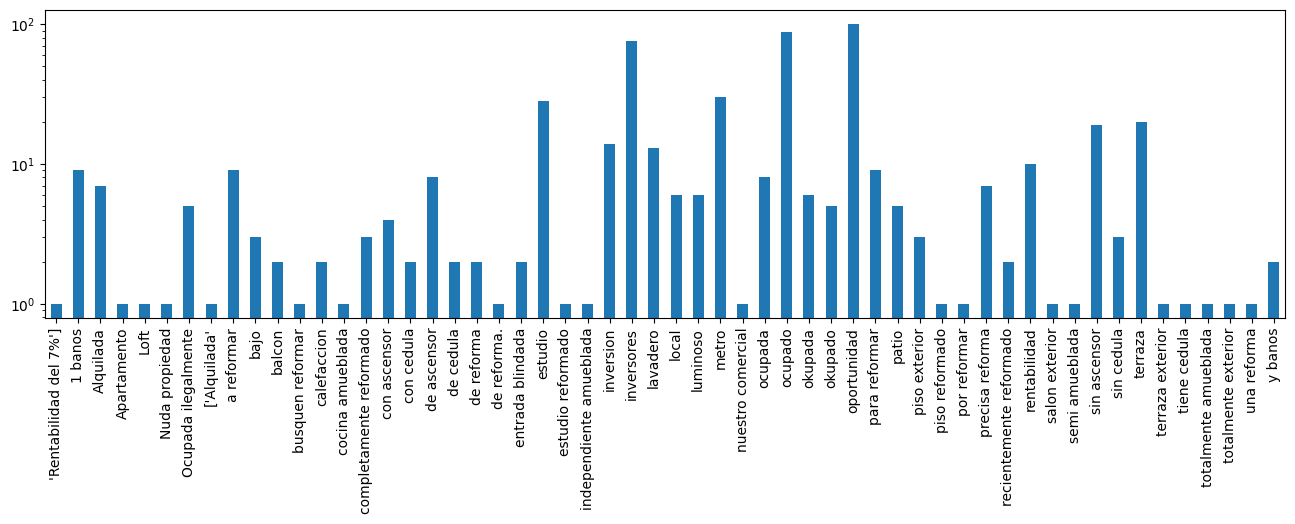

In [52]:

# Split tags into individual words and count occurrences
tag_counts = pd.Series([word.strip() for tags_list in pisos['tags'].str.split(',') for word in tags_list if word.strip()]).value_counts()
# Plot the tag counts
tag_counts.sort_index().plot(kind='bar', figsize=(16,4), logy=True)
plt.show()


In [53]:
from difflib import SequenceMatcher

places = indicadores['nombre'].unique().tolist()

def find_place(x):
    match = None
    best = 0
    for y in places:
        ratio = SequenceMatcher(None, x, y).ratio()
        if ratio == 1:
            return (y, ratio)
        if ratio > best:
            best = ratio
            match = y
    return (match if best > 0.5 else None, round(best,2))


pisos[['barrio', 'barrio_ratio']] = pd.DataFrame(pisos['town'].map(find_place).tolist(), index=pisos.index)
display(pisos.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   link            281 non-null    object 
 1   type_v          281 non-null    object 
 2   address         281 non-null    object 
 3   town            281 non-null    object 
 4   price           281 non-null    int64  
 5   price_old       15 non-null     float64
 6   info            281 non-null    object 
 7   description     281 non-null    object 
 8   tags            281 non-null    object 
 9   agent           0 non-null      float64
 10  created         281 non-null    object 
 11  n_hab           247 non-null    Int64  
 12  sup_m2          281 non-null    Int64  
 13  disponibilidad  281 non-null    object 
 14  barrio          281 non-null    object 
 15  barrio_ratio    281 non-null    float64
dtypes: Int64(2), float64(3), int64(1), object(10)
memory usage: 35.8+ KB


None

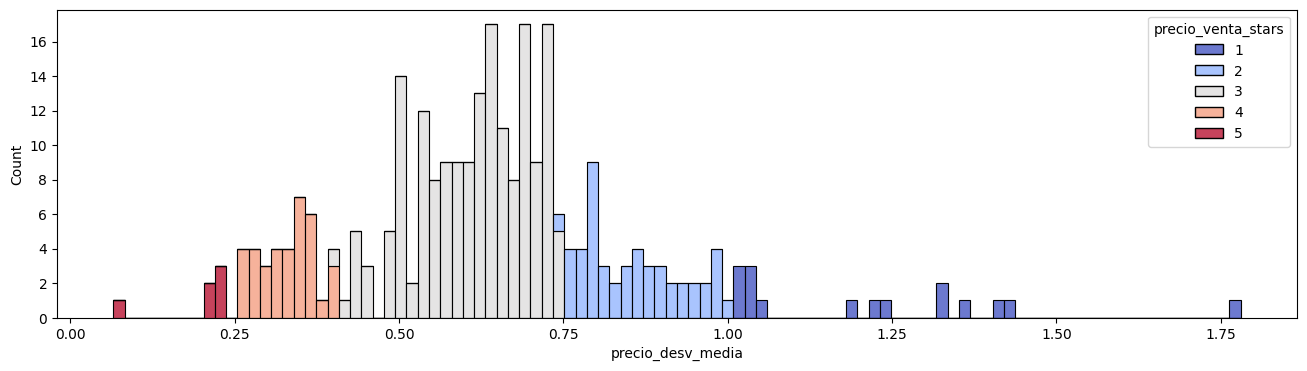

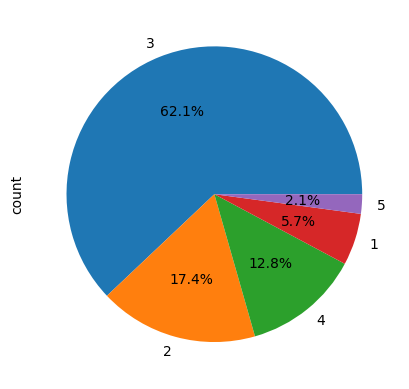

In [54]:
informe = pd.merge(pisos, indicadores, left_on='barrio', right_on='nombre', how='left')

informe['precio_m2'] = (pd.to_numeric(informe['price'], errors='coerce') / pd.to_numeric(informe['sup_m2'], errors='coerce')).astype(int)

# calcular la desviación de precio_m2 sobre precio_venta_1y (medio del último año)
informe['precio_desv_media'] = (informe['precio_m2'] / informe['precio_venta_1y']).fillna(0)

def rate_price(x):
    if x < 0.25: return 5
    if x < 0.40: return 4
    if x < 0.75: return 3
    if x < 1.00: return 2
    return 1

# calcular la puntución del precio de compra, máximo 5 stars, sobre el precio medio de venta del último (precio_venta_1y) 
informe['precio_venta_stars'] = informe['precio_desv_media'].map(rate_price)

plt.figure(figsize=(16,4))
sns.histplot(data=informe, x='precio_desv_media', bins=100, hue='precio_venta_stars', palette='coolwarm', multiple='stack')
plt.show()


# [(informe['precio_venta_stars'].fillna(0) > 2) & (informe['precio_venta_stars'].fillna(0) < 3)]
informe[['price', 'sup_m2', 'precio_m2', 'precio_venta_1y','precio_desv_media', 'precio_venta_stars']].sort_values(by='precio_desv_media', ascending=False)

informe['precio_venta_stars'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()


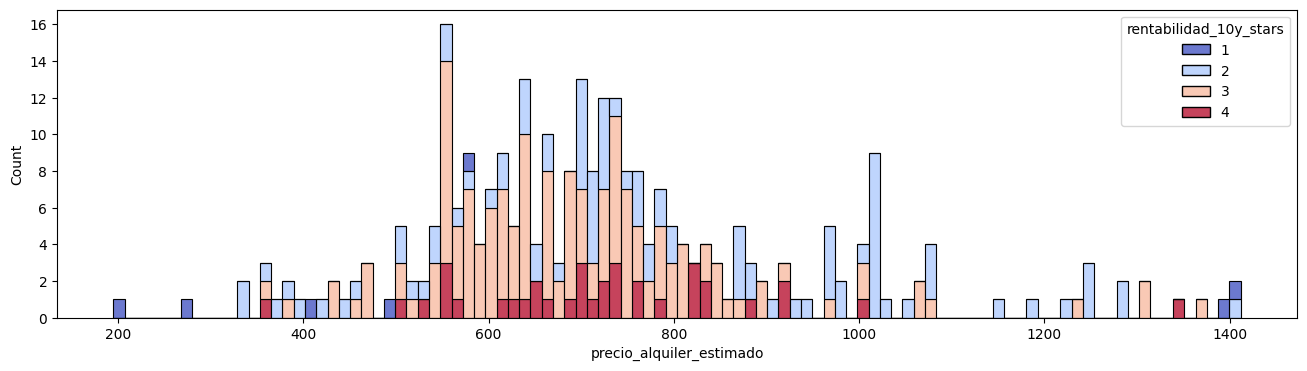

In [55]:
# display(informe.info())

informe['precio_alquiler_estimado'] = informe['precio_alquiler_1y'] * informe['sup_m2']
informe['precio_venta_estimado'] = informe['precio_venta_1y'] * informe['sup_m2']

plt.figure(figsize=(16,4))
sns.histplot(data=informe[informe['sup_m2'] <150], x='precio_alquiler_estimado', bins=100, palette='coolwarm', hue='rentabilidad_10y_stars' , multiple='stack')
plt.show()


# display(informe[informe['sup_m2'] >150].sort_values(by='sup_m2', ascending=False))

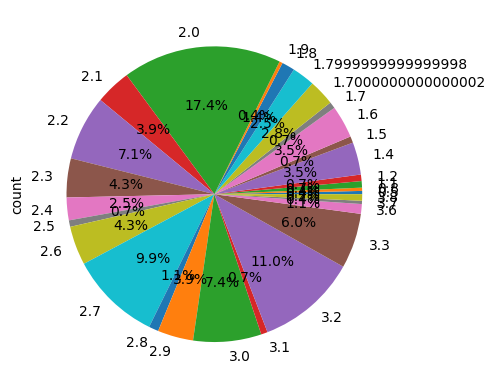

In [56]:
weights = {
    'precio_venta_stars': 0.6,        # Precio competitivo es el factor más importante
    'rentabilidad_10y_stars': 0.2,  # Rentabilidad actual
    'grow_acu_alquiler_10y_stars': 0.1, # Crecimiento histórico de alquileres
    'grow_acu_venta_10y_stars': 0.1     # Crecimiento histórico de ventas
}


informe['global_score_stars'] = round((
     informe['precio_venta_stars'] * weights['precio_venta_stars'] \
    + informe['rentabilidad_10y_stars'] * weights['rentabilidad_10y_stars'] \
    + informe['grow_acu_alquiler_10y_stars'] * weights['grow_acu_alquiler_10y_stars'] \
    + informe['grow_acu_venta_10y_stars'] * weights['grow_acu_venta_10y_stars']),1)

# Restar 0.5 estrellas si la disponibilidad es "ocupada"
informe.loc[informe['disponibilidad'] == 'ocupada', 'global_score_stars'] = informe['global_score_stars'] - 1


informe['global_score_stars'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%')
plt.show()


| Column                          | Dtype     | Descripción                                        |
|---------------------------------|-----------|---------------------------------------------------|
| link                            | object    | Enlace a la publicación del inmueble             |
| type_v                          | object    | Tipo de vivienda (casa, apartamento, etc.)       |
| address                         | object    | Dirección completa del inmueble                  |
| town                            | object    | Ciudad o localidad donde se encuentra el inmueble|
| price                           | int64     | Precio actual del inmueble                       |
| price_old                       | float64   | Precio anterior registrado                       |
| info                            | object    | Información adicional sobre el inmueble          |
| description                     | object    | Descripción del inmueble                         |
| tags                            | object    | Etiquetas asociadas al inmueble                  |
| agent                           | object    | Información sobre el agente inmobiliario         |
| created                         | object    | Fecha de creación del registro                   |
| n_hab                           | Int64     | Número de habitaciones                           |
| sup_m2                          | Int64     | Superficie en metros cuadrados                   |
| disponibilidad                  | object    | Estado de disponibilidad del inmueble            |
| barrio                          | object    | Barrio donde se encuentra el inmueble            |
| barrio_ratio                    | float64   | Ratio de certeza de la identificación del barrio |
| id                              | int64     | Identificador único del barrio                   |
| nombre                          | object    | Nombre del barrio                                |
| sup_id                          | int64     | Identificador de la localidad del barrio         |
| sup_nombre                      | object    | Nombre de la localidad del barrio                 |
| tipo                            | object    | Clasificación del tipo de localidad              |
| precio_venta_10y                | float64   | Precio promedio de venta en los últimos 10 años en el barrio |
| superficie_venta_10y            | float64   | Superficie promedio vendida en los últimos 10 años en el barrio |
| elasticidad_10y                 | float64   | Elasticidad del mercado en 10 años en el barrio              |
| precio_venta_1y                 | float64   | Precio promedio de venta en el último año en el barrio         |
| superficie_venta_1y             | float64   | Superficie promedio vendida en el último año en el barrio     |
| elasticidad_1y                  | float64   | Elasticidad del mercado en el último año en el barrio         |
| precio_venta_5y                 | float64   | Precio promedio de venta en los últimos 5 años en el barrio   |
| superficie_venta_5y             | float64   | Superficie promedio vendida en los últimos 5 años en el barrio |
| elasticidad_5y                  | float64   | Elasticidad del mercado en 5 años en el barrio               |
| precio_alquiler_10y             | float64   | Precio promedio de alquiler en los últimos 10 años en el barrio |
| rentabilidad_10y                | float64   | Rentabilidad promedio en los últimos 10 años en el barrio     |
| precio_alquiler_1y              | float64   | Precio promedio de alquiler en el último año en el barrio     |
| rentabilidad_1y                 | float64   | Rentabilidad promedio en el último año en el barrio               |
| precio_alquiler_5y              | float64   | Precio promedio de alquiler en los últimos 5 años en el barrio   |
| rentabilidad_5y                 | float64   | Rentabilidad promedio en los últimos 5 años en el barrio      |
| grow_acu_alquiler_10y           | float64   | Crecimiento acumulado del alquiler en 10 años en el barrio    |
| grow_acu_venta_10y              | float64   | Crecimiento acumulado de ventas en 10 años en el barrio       |  
| grow_acu_superficie_venta_10y   | float64   | Crecimiento acumulado de superficie vendida en 10 años en el barrio |
| grow_acu_alquiler_1y            | float64   | Crecimiento acumulado del alquiler en el último año en el barrio |
| grow_acu_venta_1y               | float64   | Crecimiento acumulado de ventas en el último año en el barrio |
| grow_acu_superficie_venta_1y    | float64   | Crecimiento acumulado de superficie vendida en el último año en el barrio |
| grow_acu_alquiler_5y            | float64   | Crecimiento acumulado del alquiler en los últimos 5 años en el barrio |
| grow_acu_venta_5y               | float64   | Crecimiento acumulado de ventas en los últimos 5 años en el barrio |
| grow_acu_superficie_venta_5y    | float64   | Crecimiento acumulado de superficie vendida en los últimos 5 años en el barrio |
| elasticidad_10y_stars           | int64     | Puntuación de elasticidad del mercado en 10 años en el barrio |
| rentabilidad_10y_stars          | int64     | Puntuación de rentabilidad en 10 años en el barrio |
| grow_acu_alquiler_10y_stars     | int64     | Puntuación de crecimiento de alquiler en 10 años en el barrio |
| grow_acu_venta_10y_stars        | int64     | Puntuación de crecimiento de ventas en 10 años en el barrio |
| precio_m2                       | int64     | Precio por metro cuadrado del inmueble                    |
| precio_desv_media               | float64   | Desviación del precio respecto a la media en el barrio   |
| precio_venta_stars              | int64     | Puntuación del precio de venta del inmueble            |
| precio_alquiler_estimado        | Float64   | Precio estimado de alquiler del inmueble               |
| precio_venta_estimado           | Float64   | Precio estimado de venta del inmueble                |
| global_score_stars               | Float64   | Puntuación global del inmueble                        |


In [57]:
print(informe.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   link                           282 non-null    object 
 1   type_v                         282 non-null    object 
 2   address                        282 non-null    object 
 3   town                           282 non-null    object 
 4   price                          282 non-null    int64  
 5   price_old                      15 non-null     float64
 6   info                           282 non-null    object 
 7   description                    282 non-null    object 
 8   tags                           282 non-null    object 
 9   agent                          0 non-null      float64
 10  created                        282 non-null    object 
 11  n_hab                          247 non-null    Int64  
 12  sup_m2                         282 non-null    Int

In [58]:
from IPython.display import HTML


columns = ['link', 'type_v', 'address', 'town', 'price', 'price_old', 'info',
       'description', 'tags', 'agent', 'created', 'n_hab', 'sup_m2',
       'disponibilidad', 'barrio', 'barrio_ratio', 'id', 'nombre', 'sup_id',
       'sup_nombre', 'tipo', 'precio_venta_10y', 'superficie_venta_10y',
       'elasticidad_10y', 'precio_venta_1y', 'superficie_venta_1y',
       'elasticidad_1y', 'precio_venta_5y', 'superficie_venta_5y',
       'elasticidad_5y', 'precio_alquiler_1y', 'rentabilidad_1y',
       'precio_alquiler_5y', 'rentabilidad_5y', 'precio_alquiler_10y',
       'rentabilidad_10y', 'grow_acu_alquiler_1y', 'grow_acu_venta_1y',
       'grow_acu_superficie_venta_1y', 'grow_acu_alquiler_5y',
       'grow_acu_venta_5y', 'grow_acu_superficie_venta_5y',
       'grow_acu_alquiler_10y', 'grow_acu_venta_10y',
       'grow_acu_superficie_venta_10y', 'elasticidad_10y_stars',
       'rentabilidad_10y_stars', 'grow_acu_alquiler_10y_stars',
       'grow_acu_venta_10y_stars', 'precio_m2', 'precio_desv_media',
       'precio_venta_stars', 'precio_alquiler_estimado',
       'precio_venta_estimado', 'global_score_stars']

informe[columns].to_csv('datasets/gen_informe.csv', index=False)


for _, row in informe[informe['global_score_stars'] > 3].sort_values(by='global_score_stars', ascending=False).iterrows():
   
   display(row.to_dict())
   display(HTML(f"""<h3>{row['type_v']} en <a href="{row['link']}">{row['address']}</a></h3>
                <b>Estrellas Globales</b>: {row['global_score_stars']}<br>
                <b>Estrellas de Precio</b>: {row['precio_venta_stars']}<br>
                <b>Estrellas de Rentabilidad</b>: {row['rentabilidad_10y_stars']}<br>
                <b>Rentabilidad</b>: {row['rentabilidad_10y'] *100:.2f} %<br>
                <b>precio</b>: {row['price']} €<br>
                <b>metros cuadrados</b>: {row['sup_m2']} m2<br>
                <b>precio_m2</b>: {row['precio_m2']} €/m2 ({row['precio_venta_stars']} estrellas) ya que es un {row['precio_desv_media']*100:.0f}% del precio medio de venta de {row['nombre']} : {row['precio_venta_1y']:.0f} €/m2<br>
                <b>precio_alquiler_estimado</b>: {row['precio_alquiler_estimado']:.0f} €/mes<br>
                <b>precio_venta_estimado</b>: {row['precio_venta_estimado']:.0f} €<br>
                <b>habitaciones</b>: {row['n_hab']}<br>
                <b>descripcion</b>: {row['description']}<br>
                <b>tags</b>: {row['tags']}<br>
                <b>barrio</b>: {row['barrio']}<br>
                <b>creado</b>: {row['created']}<br>
                <b>disponibilidad</b>: {row['disponibilidad']}<br>
                """))


{'link': 'https://www.idealista.com/inmueble/106873177/',
 'type_v': 'chalet pareado',
 'address': 'calle de llobera, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 85000,
 'price_old': nan,
 'info': "['2 hab.', '97 m²']",
 'description': 'casa adosada de 97 m² en venta, situada en barcelona. construida en 1958, esta casa adosada dispone de una superficie construida de 97 m², siendo la util de 60 m² y se distribuye en salon, cocina, 2 dormitorios y 1 bano. la vivienda esta muy bien comunicada, proxima a la estacion de metro roquetes, con parada de autobu',
 'tags': 'metro',
 'agent': nan,
 'created': '2025-01-01 12:43:17',
 'n_hab': 2,
 'sup_m2': 97,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 'rentabilidad_1y': 0

{'link': 'https://www.idealista.com/inmueble/106576974/',
 'type_v': 'estudio',
 'address': 'les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 33000,
 'price_old': nan,
 'info': "['51 m²', 'Bajo exterior sin ascensor']",
 'description': 'tecnocasa estudi mina de la ciutat s. l tiene el placer de presentarles este inmueble el cual tenemos en exclusiva:dos estudios por 33.000 cada uno, dispone de 51m² de construccion, distribuidos cada uno de ellos de la siguiente manera: un espacio diafano tipo loft donde se puede hacer la cocina americana con salon c',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:37',
 'n_hab': None,
 'sup_m2': 51,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 'rentabilidad_1y': 0.0763,
 '

{'link': 'https://www.idealista.com/inmueble/106249560/',
 'type_v': 'piso',
 'address': "calle de calabria, la nova esquerra de l'eixample, barcelona",
 'town': "la nova esquerra de l'eixample",
 'price': 75000,
 'price_old': nan,
 'info': "['3 hab.', '82 m²', 'Planta 3ª exterior con ascensor']",
 'description': 'leer antes de contactar. quedara libre tras defuncion de los usufructuarios. solo inversores. se vende la nuda propiedad. abstenerse agencias ya que la propiedad es de la empresa. precio venta 75.000 € + 890 €/mes vitalicios. sin ipc. usufructuario de 73 anos. piso tasado en 415.448 €. piso en situado en el barrio de l',
 'tags': 'Nuda propiedad, inversores',
 'agent': nan,
 'created': '2025-01-01 12:43:42',
 'n_hab': 3,
 'sup_m2': 82,
 'disponibilidad': 'alquilada',
 'barrio': "la nova esquerra de l'eixample",
 'barrio_ratio': 1.0,
 'id': 80209,
 'nombre': "la nova esquerra de l'eixample",
 'sup_id': 80200,
 'sup_nombre': 'eixample',
 'tipo': 'barri',
 'precio_venta_1y': 444

{'link': 'https://www.idealista.com/inmueble/106658473/',
 'type_v': 'piso',
 'address': 'calle de pluto, la teixonera, barcelona',
 'town': 'la teixonera',
 'price': 52000,
 'price_old': nan,
 'info': "['2 hab.', '50 m²', 'Planta -1 sin ascensor']",
 'description': 'piso a la venta de 50 m² de superficie, situado en barcelona capital. esta vivienda de segunda mano se localiza en una zona tranquila de la localidad. ubicada en zona con todo tipo de servicios alrededor. ademas cuenta con buenas comunicaciones tanto por transporte publico como por transporte privado. esta distribuida',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:32',
 'n_hab': 2,
 'sup_m2': 50,
 'disponibilidad': 'disponible',
 'barrio': 'la teixonera',
 'barrio_ratio': 1.0,
 'id': 80738,
 'nombre': 'la teixonera',
 'sup_id': 80700,
 'sup_nombre': 'horta guinardo',
 'tipo': 'barri',
 'precio_venta_1y': 2619.8571,
 'superficie_venta_1y': 456.0,
 'elasticidad_1y': -0.1742,
 'precio_alquiler_1y': 14.53,
 'renta

{'link': 'https://www.idealista.com/inmueble/105316311/',
 'type_v': 'duplex',
 'address': "paseo d'urrutia, can peguera  el turo de la peira, barcelona",
 'town': 'can peguera  el turo de la peira',
 'price': 70000,
 'price_old': nan,
 'info': "['2 hab.', '78 m²', 'Bajo exterior sin ascensor']",
 'description': 'tecnocasa presenta en exclusiva, duplex divididos en 2 estancias.planta baja de 30mts a pie de calle con mucha entrada de luz natural, \xa0 1 aseo con salida al patio de luces, y ventanas que aportan mucha luz y ventilacion\xa0y planta sotano de 38 mts. \xa0muy cerca del metro llucmajor (l4), y a 5 minutos del metro de virr',
 'tags': 'patio, metro, metro',
 'agent': nan,
 'created': '2025-01-01 12:43:44',
 'n_hab': 2,
 'sup_m2': 78,
 'disponibilidad': 'disponible',
 'barrio': 'el turo de la peira',
 'barrio_ratio': 0.75,
 'id': 80846,
 'nombre': 'el turo de la peira',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2431.4444,
 'superficie_

{'link': 'https://www.idealista.com/inmueble/101395290/',
 'type_v': 'estudio',
 'address': 'calle de la mare de deu dels angels, la teixonera, barcelona',
 'town': 'la teixonera',
 'price': 98000,
 'price_old': nan,
 'info': "['94 m²', 'Bajo exterior sin ascensor']",
 'description': "cerca parc creueta del coll y junto hospital vall d'hebron y hospital san rafael. calle mare deu dels angels, amplio local de 90 metros aproximadamente, diafano, apto para loft vivienda, entrada por calle y vestibulo, cocina, bano completo y dos aseos, puerta y ventana a la calle, comunicado por metro linea l5 y autobu",
 'tags': 'Loft, local, metro',
 'agent': nan,
 'created': '2025-01-01 12:43:56',
 'n_hab': None,
 'sup_m2': 94,
 'disponibilidad': 'disponible',
 'barrio': 'la teixonera',
 'barrio_ratio': 1.0,
 'id': 80738,
 'nombre': 'la teixonera',
 'sup_id': 80700,
 'sup_nombre': 'horta guinardo',
 'tipo': 'barri',
 'precio_venta_1y': 2619.8571,
 'superficie_venta_1y': 456.0,
 'elasticidad_1y': -0.174

{'link': 'https://www.idealista.com/inmueble/106868853/',
 'type_v': 'piso',
 'address': 'calle albania, el besos, barcelona',
 'town': 'el besos',
 'price': 68200,
 'price_old': nan,
 'info': "['3 hab.', '56 m²', 'Planta 5ª sin ascensor']",
 'description': 'vivienda sita en la calle albania, de barcelona. tiene una superficie de cuarenta y seis metros sesenta y ocho decimetros cuadrados, distribuidos en una sola planta que se compone de ingreso, cocina comedor, tres dormitorios, aseo y terraza con lavadero.  el inmueble ha sido adquirido a traves de un procedimiento judi',
 'tags': 'terraza, lavadero',
 'agent': nan,
 'created': '2025-01-01 12:43:23',
 'n_hab': 3,
 'sup_m2': 56,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio_alquiler_1y': 18.885,


{'link': 'https://www.idealista.com/inmueble/101938558/',
 'type_v': 'piso',
 'address': 'el besos, barcelona',
 'town': 'el besos',
 'price': 92000,
 'price_old': nan,
 'info': "['2 hab.', '54 m²', 'Planta 2ª ']",
 'description': 'comodo piso en barcelona, ideal para parejas. la vivienda consta de 54 m² construidos distribuidos en 2 habitaciones, salon comedor, cocina ademas de 1 bano completo. el inmueble es muy luminoso. ubicado en la 2a planta del edificio, sin ascensor. cuenta con todos los servicios necesarios a su alrededor, como la escola',
 'tags': 'luminoso, sin ascensor',
 'agent': nan,
 'created': '2025-01-01 12:43:17',
 'n_hab': 2,
 'sup_m2': 54,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio_alquiler_1y': 18.885,
 'rentabilidad_1y': 0

{'link': 'https://www.idealista.com/inmueble/106467720/',
 'type_v': 'piso',
 'address': 'el besos, barcelona',
 'town': 'el besos',
 'price': 95000,
 'price_old': nan,
 'info': "['3 hab.', '66 m²', 'Planta 1ª exterior sin ascensor']",
 'description': '¡ oportunidad!piso de 66 m² para reformar a la venta en barcelona.la vivienda se distribuye en salon comedor, tres dormitorios, cocina independiente y un cuarto de bano.es una 1ª planta en un bloque sin ascensor.cuenta con suelos de gres, ventanas de aluminio, puertas interiores de sapelly.. . precisa reforma i',
 'tags': 'oportunidad, para reformar, sin ascensor, precisa reforma ',
 'agent': nan,
 'created': '2025-01-01 12:43:37',
 'n_hab': 3,
 'sup_m2': 66,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'p

{'link': 'https://www.idealista.com/inmueble/103745734/',
 'type_v': 'piso',
 'address': 'el besos, barcelona',
 'town': 'el besos',
 'price': 92000,
 'price_old': nan,
 'info': "['3 hab.', '57 m²', 'Planta 1ª sin ascensor']",
 'description': 'funcional piso en barcelona, ideal para familias. la vivienda dispone de una superficie de 57 m² construidos distribuidos en tres habitaciones, salon comedor, cocina y un aseo. cuenta con todos los servicios necesarios a su alrededor, como la escola prim, supermercados, bancos, bibliotecas, farmacias, oficinas de corre',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:51',
 'n_hab': 3,
 'sup_m2': 57,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio_alquiler_1y': 18.885,
 'rentabilidad_1y': 0.0495,
 'g

{'link': 'https://www.idealista.com/inmueble/101939714/',
 'type_v': 'piso',
 'address': 'el besos, barcelona',
 'town': 'el besos',
 'price': 84000,
 'price_old': nan,
 'info': "['3 hab.', '66 m²', 'Planta 1ª sin ascensor']",
 'description': 'piso en barcelona. dispone de una superficie de 66 m² distribuidos en el salon comedor, 2 habitaciones, cocina, 1 bano y terraza. el piso esta situado cerca de servicios, comercios, de un centro educativo, de un centro sanitario, de paradas de autobus y entre las paradas de metro de besos mar y besos. con facil acceso',
 'tags': 'terraza, metro',
 'agent': nan,
 'created': '2025-01-01 12:43:56',
 'n_hab': 3,
 'sup_m2': 66,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio_alquiler_1y': 18.885,
 'rentabilidad_1y'

{'link': 'https://www.idealista.com/inmueble/101940416/',
 'type_v': 'piso',
 'address': 'el besos, barcelona',
 'town': 'el besos',
 'price': 88500,
 'price_old': nan,
 'info': "['3 hab.', '54 m²', 'Planta 2ª ']",
 'description': 'comodo piso en barcelona, perfecto para familias. la vivienda dispone de una superficie de 54 m² construidos distribuidos en 3 habitaciones, salon comedor, cocina ademas de 1 aseo. ubicado en el corazon de barcelona, muy cerca de ronda litoral en el barrio de call de barcelona, a escasos minutos de placa de catalunya,',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:56',
 'n_hab': 3,
 'sup_m2': 54,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio_alquiler_1y': 18.885,
 'rentabilidad_1y': 0.0495,
 'grow_acu_alqui

{'link': 'https://www.idealista.com/inmueble/102290980/',
 'type_v': 'piso',
 'address': 'el besos, barcelona',
 'town': 'el besos',
 'price': 87500,
 'price_old': nan,
 'info': "['2 hab.', '54 m²', 'Planta 3ª sin ascensor']",
 'description': 'comodo piso en barcelona, ideal para parejas. la vivienda consta de 54 m² construidos distribuidos en dos habitaciones, salon comedor, cocina y un aseo. cuenta con todos los servicios necesarios a su alrededor, como el centro sanitario cap besos centre d? atencio primaria, la escola turbula, supermercados, bancos, bibl',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:51',
 'n_hab': 2,
 'sup_m2': 54,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio_alquiler_1y': 18.885,
 'rentabilidad_1y': 0.0495,
 'g

{'link': 'https://www.idealista.com/inmueble/101240861/',
 'type_v': 'estudio',
 'address': 'calle de catania, el besos, barcelona',
 'town': 'el besos',
 'price': 82000,
 'price_old': nan,
 'info': "['48 m²']",
 'description': '¡oportunidad para comprar tu piso! situado en calle catania barcelona, se encuentra este activo inmobiliario de tipo piso, con una superficie construida de 47.5 metros cuadrados. ¡es el momento perfecto para adquirir tu nueva propiedad en barcelona! si lo deseas, puedes solicitar un recorrido virtual o una visita en pe',
 'tags': 'oportunidad',
 'agent': nan,
 'created': '2025-01-01 12:43:56',
 'n_hab': None,
 'sup_m2': 48,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio_alquiler_1y': 18.885,
 'rentabilidad_1y': 0.0495,
 'gr

{'link': 'https://www.idealista.com/inmueble/102291053/',
 'type_v': 'piso',
 'address': 'el besos, barcelona',
 'town': 'el besos',
 'price': 96000,
 'price_old': nan,
 'info': "['2 hab.', '63 m²', 'Bajo exterior sin ascensor']",
 'description': "pis a barcelona, perfecte per a parelles. l´immoble disposa d´una superficie de 63 m² construits distribuits en dues habitacions, salo menjador, cuina i un lavabo. compte amb tots els serveis necessaris al seu voltant, com l'escola prim, supermercats, bancs, biblioteques, farmacies, oficines de correus, centres esporti",
 'tags': 'Ocupada ilegalmente',
 'agent': nan,
 'created': '2025-01-01 12:43:51',
 'n_hab': 2,
 'sup_m2': 63,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio_alquiler_1y': 18.885,
 'rentab

{'link': 'https://www.idealista.com/inmueble/105540140/',
 'type_v': 'piso',
 'address': 'calle de perpinan, el besos, barcelona',
 'town': 'el besos',
 'price': 95000,
 'price_old': nan,
 'info': "['3 hab.', '66 m²', 'Planta 1ª sin ascensor']",
 'description': '¡ oportunidad! piso de 66 m² para reformar a la venta en barcelona. la vivienda se distribuye en salon comedor, tres dormitorios, cocina independiente y un cuarto de bano. es una 1ª planta en un bloque sin ascensor. cuenta con suelos de gres, ventanas de aluminio, puertas interiores de sapelly.. . precisa reforma integ',
 'tags': 'oportunidad, para reformar, sin ascensor, precisa reforma ',
 'agent': nan,
 'created': '2025-01-01 12:43:44',
 'n_hab': 3,
 'sup_m2': 66,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticida

{'link': 'https://www.idealista.com/inmueble/106518360/',
 'type_v': 'piso',
 'address': 'calle de caller, el besos, barcelona',
 'town': 'el besos',
 'price': 80000,
 'price_old': nan,
 'info': "['2 hab.', '51 m²', 'Planta 1ª exterior sin ascensor']",
 'description': '¡ oportunidad!piso tapiado de dos dormitorios para reformar a la venta en barcelona.la vivienda esta distribuida en salon comedor, dos dormitorios, un cuarto de bano, cocina independiente y terraza con lavadero.cuenta con suelos de gres, ventanas de aluminio, puertas interiores de sapelly.. . precisa reforma integ',
 'tags': 'oportunidad, terraza, lavadero, para reformar, precisa reforma ',
 'agent': nan,
 'created': '2025-01-01 12:43:37',
 'n_hab': 2,
 'sup_m2': 51,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'ela

{'link': 'https://www.idealista.com/inmueble/102609582/',
 'type_v': 'piso',
 'address': 'calle de palerm, el besos, barcelona',
 'town': 'el besos',
 'price': 62000,
 'price_old': nan,
 'info': "['2 hab.', '53 m²', 'Planta 2ª sin ascensor']",
 'description': 'piso a reformar en barcelona. la vivienda tiene 47,6m2. y esta distribuido en salon comedor, dos habitaciones, bano con banera y cocina. cuenta con puerta de entrada blindada normal, cocina y banos con paredes alicatadas, carpinteria interior en madera y suelos de gres. situado en un edificio plurifamiliar de 6 alturas',
 'tags': 'a reformar, entrada blindada, y banos',
 'agent': nan,
 'created': '2025-01-01 12:43:42',
 'n_hab': 2,
 'sup_m2': 53,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio

{'link': 'https://www.idealista.com/inmueble/104873548/',
 'type_v': 'piso',
 'address': 'el besos, barcelona',
 'town': 'el besos',
 'price': 93000,
 'price_old': nan,
 'info': "['3 hab.', '61 m²', ' sin ascensor']",
 'description': 'piso situado en edificio en manzana abierta de 6 plantas sobre rasante y 1 sotano bajo rasante. se compone de cocina comedor, tres dormitorios, aseo y terraza con lavadero.',
 'tags': 'bajo, terraza, lavadero',
 'agent': nan,
 'created': '2025-01-01 12:43:49',
 'n_hab': 3,
 'sup_m2': 61,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio_alquiler_1y': 18.885,
 'rentabilidad_1y': 0.0495,
 'grow_acu_alquiler_1y': -0.1266468462166258,
 'grow_acu_venta_1y': -0.0140474310192165,
 'grow_acu_superficie_venta_1y': -0.263360246059

{'link': 'https://www.idealista.com/inmueble/106298225/',
 'type_v': 'piso',
 'address': 'calle de caller, el besos, barcelona',
 'town': 'el besos',
 'price': 80000,
 'price_old': nan,
 'info': "['2 hab.', '51 m²', 'Planta 1ª exterior sin ascensor']",
 'description': '¡ oportunidad! piso tapiado de dos dormitorios para reformar a la venta en barcelona. la vivienda esta distribuida en salon comedor, dos dormitorios, un cuarto de bano, cocina independiente y terraza con lavadero. cuenta con suelos de gres, ventanas de aluminio, puertas interiores de sapelly.. . precisa reforma integra',
 'tags': 'oportunidad, terraza, lavadero, para reformar, precisa reforma ',
 'agent': nan,
 'created': '2025-01-01 12:43:42',
 'n_hab': 2,
 'sup_m2': 51,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,


{'link': 'https://www.idealista.com/inmueble/106461725/',
 'type_v': 'piso',
 'address': 'calle de caller, el besos, barcelona',
 'town': 'el besos',
 'price': 80000,
 'price_old': nan,
 'info': "['2 hab.', '51 m²', 'Planta 1ª exterior sin ascensor']",
 'description': '¡ oportunidad!piso tapiado de dos dormitorios para reformar a la venta en barcelona.la vivienda esta distribuida en salon comedor, dos dormitorios, un cuarto de bano, cocina independiente y terraza con lavadero.cuenta con suelos de gres, ventanas de aluminio, puertas interiores de sapelly.. . precisa reforma inte',
 'tags': 'oportunidad, terraza, lavadero, para reformar, precisa reforma ',
 'agent': nan,
 'created': '2025-01-01 12:43:37',
 'n_hab': 2,
 'sup_m2': 51,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elas

{'link': 'https://www.idealista.com/inmueble/89362270/',
 'type_v': 'piso',
 'address': 'calle de tarent, el besos, barcelona',
 'town': 'el besos',
 'price': 67200,
 'price_old': nan,
 'info': "['3 hab.', '52 m²', 'Planta 1ª sin ascensor']",
 'description': 'piso con terraza a la venta en barcelona ciudad (barcelona). esta situado en la primera planta de un edificio residencial dotado de portero automatico. se distribuye en un salon con acceso a la terraza y a un pequeno cuarto trastero, 3 dormitorios, cocina amueblada integrada en el salon, 1 bano equipado con plato de du',
 'tags': 'terraza, terraza, cocina amueblada',
 'agent': nan,
 'created': '2025-01-01 12:43:37',
 'n_hab': 3,
 'sup_m2': 52,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio_alq

{'link': 'https://www.idealista.com/inmueble/106873319/',
 'type_v': 'piso',
 'address': 'calle de marsala, el besos, barcelona',
 'town': 'el besos',
 'price': 80000,
 'price_old': nan,
 'info': "['2 hab.', '50 m²', 'Planta 3ª sin ascensor']",
 'description': 'inmueble a la venta en la ciudad de barcelona. se localiza en una zona consolidada con caracter urbano y residencial, situado a pocos minutos del centro de la poblacion, rodeado por fincas de similares caracteristicas. dispone de equipamientos suficientes en el entorno como: medico sanitario, docente, religioso, comerc',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:17',
 'n_hab': 2,
 'sup_m2': 50,
 'disponibilidad': 'disponible',
 'barrio': 'el poblenou',
 'barrio_ratio': 0.63,
 'id': 81068,
 'nombre': 'el poblenou',
 'sup_id': 81000,
 'sup_nombre': 'sant marti',
 'tipo': 'barri',
 'precio_venta_1y': 4577.7778,
 'superficie_venta_1y': 2220.6667,
 'elasticidad_1y': 0.7777,
 'precio_alquiler_1y': 18.885,
 'rentabilida

{'link': 'https://www.idealista.com/inmueble/97894860/',
 'type_v': 'piso',
 'address': 'calle de rodrigo caro, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 65000,
 'price_old': 67000.0,
 'info': "['1 hab.', '50 m²', ' sin ascensor']",
 'description': 'piso situado en la planta baja de un edificio de cinco plantas sobre rasante y un sotano. no dispone de ascensor. esta situado en la localidad y provincia de barcelona. posee una superficie construida aproximada de 50 m² que se distribuyen en salon comedor, cocina, dormitorio, un bano, un aseo, lavadero y trastero. pos',
 'tags': 'lavadero, de ascensor',
 'agent': nan,
 'created': '2025-01-01 12:43:17',
 'n_hab': 1,
 'sup_m2': 50,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y'

{'link': 'https://www.idealista.com/inmueble/103175828/',
 'type_v': 'piso',
 'address': 'calle de la mare de deu de lorda, la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 96000,
 'price_old': nan,
 'info': "['3 hab.', '67 m²', 'Planta 3ª exterior sin ascensor']",
 'description': '¡ oportunidad para reformar! piso para reformar de 67 m² construidos (60 m² utiles) distribuidos en salon comedor, tres dormitorios, cocina independiente, cuarto de bano y vestibulo. precisa reforma integral ya que se encuentra en mal estado de conservacion, por lo que no admite visitas. ofrece muchas posibilidades de',
 'tags': 'oportunidad, para reformar, para reformar, precisa reforma ',
 'agent': nan,
 'created': '2025-01-01 12:43:51',
 'n_hab': 3,
 'sup_m2': 67,
 'disponibilidad': 'disponible',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062

{'link': 'https://www.idealista.com/inmueble/106868603/',
 'type_v': 'piso',
 'address': 'calle de catasus, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 79000,
 'price_old': nan,
 'info': "['3 hab.', '59 m²', 'Planta 1ª sin ascensor']",
 'description': 'excelente piso de tres dormitorios y un bano. se encuentra en la planta primera de un edificio residencial de tres plantas sobre rasante. sin ascensor. situado en el municipio de barcelona. construido en el ano 1958. la vivienda se distribuye en tres dormitorios, amplio salon comedor, cocina independiente y un cuarto d',
 'tags': 'sin ascensor',
 'agent': nan,
 'created': '2025-01-01 12:43:23',
 'n_hab': 3,
 'sup_m2': 59,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925

{'link': 'https://www.idealista.com/inmueble/104825720/',
 'type_v': 'piso',
 'address': 'calle del pare perez del pulgar, la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 47500,
 'price_old': nan,
 'info': "['3 hab.', '42 m²', 'Planta 1ª sin ascensor']",
 'description': 'vivienda en el municipio de barcelona, provincia de barcelona. el inmueble se encuentra en una zona tranquila, rodeado por viviendas residenciales de similares caracteristicas. cuenta con facil acceso a la carretera y otros nudos de comunicacion. cercano a establecimientos y comercios de la zona.',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:28',
 'n_hab': 3,
 'sup_m2': 42,
 'disponibilidad': 'disponible',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0,
 'elasticidad_1y': -0.1425,
 'precio_alquiler_1y': 13

{'link': 'https://www.idealista.com/inmueble/106431517/',
 'type_v': 'piso',
 'address': 'calle de catasus, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 89800,
 'price_old': nan,
 'info': "['1 hab.', '55 m²', ' sin ascensor']",
 'description': 'piso de 55 m² en venta, situado en barcelona. construida en 1963, esta vivienda cuenta con una superficie de 55 m² y se distribuye en varias estancias. la vivienda esta comunicada mediante el acceso viario b 20. la zona dispone de equipamiento variado, centro de salud, gimnasios, parque, escuela de arte, etc. con nuest',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:28',
 'n_hab': 1,
 'sup_m2': 55,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 'rentabilidad_1y':

{'link': 'https://www.idealista.com/inmueble/106870277/',
 'type_v': 'piso',
 'address': 'plaza de la trinitat, la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 96700,
 'price_old': nan,
 'info': "['4 hab.', '75 m²', 'Planta 4ª sin ascensor']",
 'description': 'vivienda piso en la plaza trinitat de barcelona.  el inmueble se transmite arrendado a tercero y con un posible derecho de este a la adquisicion preferente del mismo. el inmueble se transmitira: (i) como cuerpo cierto y a tanto alzado (ii) como un todo, inseparable (iii) en el estado registral y catastral en el que se',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:23',
 'n_hab': 4,
 'sup_m2': 75,
 'disponibilidad': 'alquilada',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0,
 'elasticidad_1y': -0.1425,
 'precio_alquil

{'link': 'https://www.idealista.com/inmueble/106870189/',
 'type_v': 'piso',
 'address': 'calle de romani, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 58300,
 'price_old': nan,
 'info': "['3 hab.', '47 m²', 'Planta 2ª sin ascensor']",
 'description': 'vivienda en el municipio de barcelona, provincia de barcelona. el inmueble se encuentra en una zona tranquila, rodeado por viviendas residenciales de similares caracteristicas. cuenta con facil acceso a la carretera y otros nudos de comunicacion. cercano a establecimientos y comercios de la zona.  el inmueble se trans',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:23',
 'n_hab': 3,
 'sup_m2': 47,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 'rentabilid

{'link': 'https://www.idealista.com/inmueble/106869703/',
 'type_v': 'piso',
 'address': 'calle de llopis, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 93400,
 'price_old': nan,
 'info': "['4 hab.', '66 m²', ' sin ascensor']",
 'description': 'piso de 66 m² en venta, situado en barcelona. construido en 1971, este piso cuenta con una superficie de 66 m² y se distribuye en salon comedor, cocina, 4 dormitorios y 1 bano. la vivienda esta comunicada mediante la estacion de metro roquetes, autobuses con las lineas 134 y 127 y por carretera, mediante el acceso b 20',
 'tags': 'metro',
 'agent': nan,
 'created': '2025-01-01 12:43:23',
 'n_hab': 4,
 'sup_m2': 66,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 'rentabilidad_

{'link': 'https://www.idealista.com/inmueble/106869628/',
 'type_v': 'piso',
 'address': 'calle del torrent de la perera, la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 53300,
 'price_old': nan,
 'info': "['2 hab.', '46 m²', 'Planta 1ª sin ascensor']",
 'description': 'piso situado en la 1º planta de un edificio plurifamiliar bajo rasante con 2 alturas en el municipio de barcelona, provincia de barcelona. la vivienda tiene 41,92m2. el inmueble se encuentra en una zona tranquila, rodeado por viviendas residenciales de similares caracteristicas. cuenta con facil acceso a la carretera y',
 'tags': 'bajo',
 'agent': nan,
 'created': '2025-01-01 12:43:23',
 'n_hab': 2,
 'sup_m2': 46,
 'disponibilidad': 'disponible',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0,
 'elasticidad_1y': -0.1425,

{'link': 'https://www.idealista.com/inmueble/106870368/',
 'type_v': 'piso',
 'address': 'calle de la foradada, la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 100000,
 'price_old': nan,
 'info': "['3 hab.', '92 m²', ' sin ascensor']",
 'description': 'piso de 93 m², de 32 dormitorios y 1 banos, en venta en barcelona. se trata de un piso de 93 m² distribuidos en salon comedor, cocina, 3 dormitorios y 1 banos. la vivienda se situa en el barrio periferico de la trinitat vella, teniendo buenos accesos por carretera. tambien ofrece conexion por transporte publico al esta',
 'tags': '1 banos, 1 banos',
 'agent': nan,
 'created': '2025-01-01 12:43:23',
 'n_hab': 3,
 'sup_m2': 92,
 'disponibilidad': 'disponible',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0,
 'elasticidad_1y': -0.1425,
 'pre

{'link': 'https://www.idealista.com/inmueble/106870711/',
 'type_v': 'piso',
 'address': 'calle del pare perez del pulgar, la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 47500,
 'price_old': nan,
 'info': "['3 hab.', '42 m²', 'Planta 1ª sin ascensor']",
 'description': 'vivienda en el municipio de barcelona, provincia de barcelona. el inmueble se encuentra en una zona tranquila, rodeado por viviendas residenciales de similares caracteristicas. cuenta con facil acceso a la carretera y otros nudos de comunicacion. cercano a establecimientos y comercios de la zona.',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:23',
 'n_hab': 3,
 'sup_m2': 42,
 'disponibilidad': 'disponible',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0,
 'elasticidad_1y': -0.1425,
 'precio_alquiler_1y': 13

{'link': 'https://www.idealista.com/inmueble/106871134/',
 'type_v': 'piso',
 'address': 'calle del pare perez del pulgar, la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 60500,
 'price_old': nan,
 'info': "['1 hab.', '55 m²', 'Planta 2ª sin ascensor']",
 'description': 'vivienda en el municipio de barcelona, provincia de barcelona. el inmueble se encuentra en una zona tranquila, rodeado por viviendas residenciales de similares caracteristicas. cuenta con facil acceso a la carretera y otros nudos de comunicacion. cercano a establecimientos y comercios de la zona.  el inmueble ha sido',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:23',
 'n_hab': 1,
 'sup_m2': 55,
 'disponibilidad': 'disponible',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0,
 'elasticidad_1y': -0.1425,
 'pr

{'link': 'https://www.idealista.com/inmueble/106871496/',
 'type_v': 'piso',
 'address': 'calle de la cantera, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 58900,
 'price_old': nan,
 'info': "['3 hab.', '53 m²', ' sin ascensor']",
 'description': 'vivienda en la calle mina de la ciudad, de barcelona, barriada de san andres de palomar; tiene una superficie de cincuenta y tres metros y treinta y un decimetros cuadrados. se compone de recibidor, lavadero, aseo, cocina, comedor, y tres dormitorios.  el inmueble se transmite arrendado a tercero y con un posible dere',
 'tags': 'lavadero',
 'agent': nan,
 'created': '2025-01-01 12:43:17',
 'n_hab': 3,
 'sup_m2': 53,
 'disponibilidad': 'alquilada',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 'rentabil

{'link': 'https://www.idealista.com/inmueble/106883157/',
 'type_v': 'piso',
 'address': 'calle de rodrigo caro, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 65000,
 'price_old': nan,
 'info': "['1 hab.', '50 m²', ' sin ascensor']",
 'description': 'piso situado en la planta baja de un edificio de cinco plantas sobre rasante y un sotano. no dispone de ascensor. esta situado en la localidad y provincia de barcelona. posee una superficie construida aproximada de 50 m² que se distribuyen en salon comedor, cocina, dormitorio, un bano, un aseo, lavadero y trastero. pos',
 'tags': 'lavadero, de ascensor',
 'agent': nan,
 'created': '2025-01-01 12:43:17',
 'n_hab': 1,
 'sup_m2': 50,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 1

{'link': 'https://www.idealista.com/inmueble/106894608/',
 'type_v': 'estudio',
 'address': 'calle de simancas, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 75000,
 'price_old': nan,
 'info': "['56 m²', 'Bajo interior con ascensor']",
 'description': '¡descubre el potencial de este encantador estudio en venta! situado en una ubicacion tranquila pero perfectamente comunicada, este espacio de 59 m² construidos y 56 m² utiles es una joya esperando ser transformada. con una distribucion excelente y accesibilidad inmejorable, ofrece dos habitaciones dobles y un amplio sa',
 'tags': 'estudio',
 'agent': nan,
 'created': '2025-01-01 12:43:17',
 'n_hab': None,
 'sup_m2': 56,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 '

{'link': 'https://www.idealista.com/inmueble/106872756/',
 'type_v': 'piso',
 'address': 'calle de llobera, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 64800,
 'price_old': nan,
 'info': "['2 hab.', '55 m²', ' sin ascensor']",
 'description': 'vivienda en el municipio de badalona, provincia de barcelona. el inmueble se encuentra en una zona tranquila, rodeado por viviendas residenciales de similares caracteristicas. cuenta con facil acceso a la carretera y otros nudos de comunicacion. cercano a establecimientos y comercios de la zona.  el inmueble ha sido a',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:17',
 'n_hab': 2,
 'sup_m2': 55,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 'rentabilidad_1y': 

{'link': 'https://www.idealista.com/inmueble/106872750/',
 'type_v': 'piso',
 'address': 'calle de la mare de deu de lorda, la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 99300,
 'price_old': nan,
 'info': "['4 hab.', '98 m²', 'Planta 2ª sin ascensor']",
 'description': 'vivienda piso en la calle mare de deu de lorda, en la provincia de barcelona.  el inmueble se transmite arrendado a tercero y con un posible derecho de este a la adquisicion preferente del mismo. el inmueble se transmitira: (i) como cuerpo cierto y a tanto alzado (ii) como un todo, inseparable (iii) en el estado regis',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:17',
 'n_hab': 4,
 'sup_m2': 98,
 'disponibilidad': 'alquilada',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0,
 'elasticidad_1y': -0.1425,
 'p

{'link': 'https://www.idealista.com/inmueble/104825848/',
 'type_v': 'piso',
 'address': 'calle de la mina de la ciutat, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 70100,
 'price_old': nan,
 'info': "['3 hab.', '60 m²', 'Entreplanta sin ascensor']",
 'description': 'vivienda piso en la calle mina de la ciutat de barcelona.  el inmueble se transmite arrendado a tercero y con un posible derecho de este a la adquisicion preferente del mismo. el inmueble se transmitira: (i) como cuerpo cierto y a tanto alzado (ii) como un todo, inseparable (iii) en el estado registral y catastral en',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:49',
 'n_hab': 3,
 'sup_m2': 60,
 'disponibilidad': 'alquilada',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925

{'link': 'https://www.idealista.com/inmueble/104826045/',
 'type_v': 'piso',
 'address': 'calle de la mare de deu de lorda, la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 99300,
 'price_old': nan,
 'info': "['4 hab.', '98 m²', 'Planta 2ª sin ascensor']",
 'description': 'vivienda piso en la calle mare de deu de lorda, en la provincia de barcelona.  el inmueble se transmite arrendado a tercero y con un posible derecho de este a la adquisicion preferente del mismo. el inmueble se transmitira: (i) como cuerpo cierto y a tanto alzado (ii) como un todo, inseparable (iii) en el estado regis',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:49',
 'n_hab': 4,
 'sup_m2': 98,
 'disponibilidad': 'alquilada',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0,
 'elasticidad_1y': -0.1425,
 'p

{'link': 'https://www.idealista.com/inmueble/105663015/',
 'type_v': 'estudio',
 'address': 'les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 38500,
 'price_old': nan,
 'info': "['40 m²', 'Sótano interior sin ascensor']",
 'description': 'tecnocasa estudi mina de la ciutat s. l tiene el placer de presentarles este inmueble el cual tenemos en cartera:local convertido en loft, consta de un concepto abierto para lo que seria el el salon comedor y zona de descanso, cocina cerrada y cuarto de bano, consta de una terraza comunitaria. el inmueble se encuent',
 'tags': 'Alquilada, local, terraza',
 'agent': nan,
 'created': '2025-01-01 12:43:42',
 'n_hab': None,
 'sup_m2': 40,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 're

{'link': 'https://www.idealista.com/inmueble/104917982/',
 'type_v': 'piso',
 'address': 'calle de la mare de deu de lorda, la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 96000,
 'price_old': nan,
 'info': "['3 hab.', '67 m²', ' sin ascensor']",
 'description': 'oportunidad de adquirir un piso en calle de la mare de deu de lorda, barcelona. consta de 67 m² construidos distribuidos en tres dormitorios, cocina independiente, cuarto de bano, vestibulo y salon comedor.es una 3ª planta en un bloque sin ascensor.precisa reforma integral ya que se encuentra en mal estado de conser',
 'tags': 'oportunidad, sin ascensor, precisa reforma ',
 'agent': nan,
 'created': '2025-01-01 12:43:44',
 'n_hab': 3,
 'sup_m2': 67,
 'disponibilidad': 'disponible',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0

{'link': 'https://www.idealista.com/inmueble/102610114/',
 'type_v': 'piso',
 'address': 'calle de llopis, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 93400,
 'price_old': nan,
 'info': "['4 hab.', '66 m²', ' sin ascensor']",
 'description': 'piso de 66 m² en venta, situado en barcelona. construido en 1971, este piso cuenta con una superficie de 66 m² y se distribuye en salon comedor, cocina, 4 dormitorios y 1 bano. la vivienda esta comunicada mediante la estacion de metro roquetes, autobuses con las lineas 134 y 127 y por carretera, mediante el acceso b 20',
 'tags': 'metro',
 'agent': nan,
 'created': '2025-01-01 12:43:42',
 'n_hab': 4,
 'sup_m2': 66,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 'rentabilidad_

{'link': 'https://www.idealista.com/inmueble/106438858/',
 'type_v': 'piso',
 'address': 'la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 99000,
 'price_old': nan,
 'info': "['4 hab.', '80 m²', 'Bajo exterior sin ascensor']",
 'description': '¡solo inversores¡ vivienda no disponible para vivir! se vende la nuda propiedad de la vivienda con el usufructo vitalicio a favor del actual propietario.condiciones de la operacion y forma de pago: usufructuario: sr. 74 anos. un unico pago de 99.000. €.reparticion de los gastos del inmueble: asumir los gasto',
 'tags': 'inversores',
 'agent': nan,
 'created': '2025-01-01 12:43:37',
 'n_hab': 4,
 'sup_m2': 80,
 'disponibilidad': 'alquilada',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0,
 'elasticidad_1y': -0.1425,
 'precio_alquiler_1y': 13.37,
 'r

{'link': 'https://www.idealista.com/inmueble/105571570/',
 'type_v': 'piso',
 'address': 'calle de catasus, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 79000,
 'price_old': nan,
 'info': "['3 hab.', '59 m²', 'Planta 1ª sin ascensor']",
 'description': 'excelente piso de tres dormitorios y un bano. se encuentra en la planta primera de un edificio residencial de tres plantas sobre rasante. sin ascensor. situado en el municipio de barcelona. construido en el ano 1958. la vivienda se distribuye en tres dormitorios, amplio salon comedor, cocina independiente y un cuarto d',
 'tags': 'sin ascensor',
 'agent': nan,
 'created': '2025-01-01 12:43:44',
 'n_hab': 3,
 'sup_m2': 59,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925

{'link': 'https://www.idealista.com/inmueble/104825853/',
 'type_v': 'piso',
 'address': 'calle de la cantera, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 58900,
 'price_old': nan,
 'info': "['3 hab.', '53 m²', ' sin ascensor']",
 'description': 'vivienda en la calle mina de la ciudad, de barcelona, barriada de san andres de palomar; tiene una superficie de cincuenta y tres metros y treinta y un decimetros cuadrados. se compone de recibidor, lavadero, aseo, cocina, comedor, y tres dormitorios.  el inmueble se transmite arrendado a tercero y con un posible dere',
 'tags': 'lavadero',
 'agent': nan,
 'created': '2025-01-01 12:43:49',
 'n_hab': 3,
 'sup_m2': 53,
 'disponibilidad': 'alquilada',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 'rentabil

{'link': 'https://www.idealista.com/inmueble/103003664/',
 'type_v': 'piso',
 'address': "calle d'alcantara, les roquetes, barcelona",
 'town': 'les roquetes',
 'price': 81000,
 'price_old': nan,
 'info': "['2 hab.', '52 m²', 'Planta 3ª sin ascensor']",
 'description': 'vivienda piso a reformar ubicada en la calle alcantara en les roquetes, barcelona. el inmueble tiene una superficie aproximada de 52 m2. y esta distribuido en salon comedor, dos habitaciones, bano completo con banera y cocina semi amueblada con muebles altos y bajos. la vivienda cuenta con puerta de entrada blindada no',
 'tags': 'a reformar, semi amueblada, entrada blindada',
 'agent': nan,
 'created': '2025-01-01 12:43:51',
 'n_hab': 2,
 'sup_m2': 52,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.11

{'link': 'https://www.idealista.com/inmueble/103946158/',
 'type_v': 'duplex',
 'address': 'paseo universal, horta, barcelona',
 'town': 'horta',
 'price': 83000,
 'price_old': nan,
 'info': "['89 m²', 'Bajo exterior sin ascensor']",
 'description': 'tecnocasa presenta en exclusiva estudio duplex de 89 m2 construidos, distribuido en 2 estancias. excelente ubicacion, en el paseo universal.duplex divididos en 2 estancias, planta baja a pie de calle con mucha entrada de luz natural, y un montacargas que baja a la planta sotano, 2 habitaciones, 1 aseo con salida al p',
 'tags': 'estudio',
 'agent': nan,
 'created': '2025-01-01 12:43:51',
 'n_hab': None,
 'sup_m2': 89,
 'disponibilidad': 'disponible',
 'barrio': 'horta',
 'barrio_ratio': 1.0,
 'id': 80743,
 'nombre': 'horta',
 'sup_id': 80700,
 'sup_nombre': 'horta guinardo',
 'tipo': 'barri',
 'precio_venta_1y': 3351.8889,
 'superficie_venta_1y': 918.0,
 'elasticidad_1y': -0.2617,
 'precio_alquiler_1y': 14.41,
 'rentabilidad_1y': 0.0516,
 

{'link': 'https://www.idealista.com/inmueble/99953574/',
 'type_v': 'piso',
 'address': 'la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 88000,
 'price_old': nan,
 'info': "['3 hab.', '58 m²', 'Planta 2ª sin ascensor']",
 'description': 'comodo piso en barcelona, idoneo para familias. el inmueble consta de 58 m² construidos distribuidos en tres habitaciones, salon comedor, cocina y un aseo. en sus alrededores encontramos el institut escola rec comtal, supermercados, bancos, bibliotecas, farmacias, centros deportivos y la estacion de metro can zam. a 20',
 'tags': 'metro',
 'agent': nan,
 'created': '2025-01-01 12:43:49',
 'n_hab': 3,
 'sup_m2': 58,
 'disponibilidad': 'disponible',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0,
 'elasticidad_1y': -0.1425,
 'precio_alquiler_1y': 13.37,
 

{'link': 'https://www.idealista.com/inmueble/104825636/',
 'type_v': 'piso',
 'address': 'calle de romani, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 58300,
 'price_old': nan,
 'info': "['3 hab.', '47 m²', 'Planta 2ª sin ascensor']",
 'description': 'vivienda en el municipio de barcelona, provincia de barcelona. el inmueble se encuentra en una zona tranquila, rodeado por viviendas residenciales de similares caracteristicas. cuenta con facil acceso a la carretera y otros nudos de comunicacion. cercano a establecimientos y comercios de la zona.  el inmueble se trans',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:49',
 'n_hab': 3,
 'sup_m2': 47,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 'rentabilid

{'link': 'https://www.idealista.com/inmueble/86566928/',
 'type_v': 'estudio',
 'address': 'calle de la mina de la ciutat, 52, les roquetes, barcelona',
 'town': 'les roquetes',
 'price': 83000,
 'price_old': nan,
 'info': "['60 m²', 'Semi-sótano exterior sin ascensor']",
 'description': 'ideal inversion!piso de 60m2, 2 habitaciones, salon comedor, cocina y bano completoreformado a estrenar!unico en la zona.',
 'tags': 'inversion',
 'agent': nan,
 'created': '2025-01-01 12:43:56',
 'n_hab': None,
 'sup_m2': 60,
 'disponibilidad': 'disponible',
 'barrio': 'les roquetes',
 'barrio_ratio': 1.0,
 'id': 80850,
 'nombre': 'les roquetes',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2191.0,
 'superficie_venta_1y': 445.0,
 'elasticidad_1y': -0.1124,
 'precio_alquiler_1y': 13.925,
 'rentabilidad_1y': 0.0763,
 'grow_acu_alquiler_1y': -0.1657282282282283,
 'grow_acu_venta_1y': 0.0766584766584766,
 'grow_acu_superficie_venta_1y': -0.2557986390575839,
 'preci

{'link': 'https://www.idealista.com/inmueble/104825641/',
 'type_v': 'piso',
 'address': 'plaza de la trinitat, la trinitat vella, barcelona',
 'town': 'la trinitat vella',
 'price': 96700,
 'price_old': nan,
 'info': "['4 hab.', '75 m²', 'Planta 4ª sin ascensor']",
 'description': 'vivienda piso en la plaza trinitat de barcelona.  el inmueble se transmite arrendado a tercero y con un posible derecho de este a la adquisicion preferente del mismo. el inmueble se transmitira: (i) como cuerpo cierto y a tanto alzado (ii) como un todo, inseparable (iii) en el estado registral y catastral en el que se',
 'tags': '',
 'agent': nan,
 'created': '2025-01-01 12:43:49',
 'n_hab': 4,
 'sup_m2': 75,
 'disponibilidad': 'alquilada',
 'barrio': 'la trinitat vella',
 'barrio_ratio': 1.0,
 'id': 80957,
 'nombre': 'la trinitat vella',
 'sup_id': 80900,
 'sup_nombre': 'sant andreu',
 'tipo': 'barri',
 'precio_venta_1y': 2062.6667,
 'superficie_venta_1y': 824.0,
 'elasticidad_1y': -0.1425,
 'precio_alquil

{'link': 'https://www.idealista.com/inmueble/102769004/',
 'type_v': 'piso',
 'address': "calle d'aiguablava, la trinitat nova, barcelona",
 'town': 'la trinitat nova',
 'price': 58800,
 'price_old': nan,
 'info': "['2 hab.', '45 m²', 'Planta 3ª sin ascensor']",
 'description': 'piso de 45 m2 situado en edificio de 5 plantas sobre rasante ubicado en la ciudad de barcelona provincia de barcelona. construido en el ano 1963 no dispone de ascensor se encuentra situado en zona urbana bien comunicada y rodeada de viviendas de similares caracteristicas con todos los servicios cercanos y accesibles. ',
 'tags': 'de ascensor',
 'agent': nan,
 'created': '2025-01-01 12:43:37',
 'n_hab': 2,
 'sup_m2': 45,
 'disponibilidad': 'disponible',
 'barrio': 'la trinitat nova',
 'barrio_ratio': 1.0,
 'id': 80853,
 'nombre': 'la trinitat nova',
 'sup_id': 80800,
 'sup_nombre': 'nou barris',
 'tipo': 'barri',
 'precio_venta_1y': 2099.6667,
 'superficie_venta_1y': 625.5,
 'elasticidad_1y': 0.0253,
 'precio_al

{'link': 'https://www.idealista.com/inmueble/106505695/',
 'type_v': 'estudio',
 'address': 'paseo de la mare de deu del coll, el coll, barcelona',
 'town': 'el coll',
 'price': 95000,
 'price_old': 130000.0,
 'info': "['93 m²', 'Bajo exterior sin ascensor']",
 'description': 'estudio en gracia, con 93 m² construidos, 75 m² utiles, 1 banos, buen estado, exterior, planta baja, cocina cocina office, orientacion noroeste, 1975, 4 plantas del edificio, agua caliente individual, energia agua electrica, gastos de comunidad/mes de 58 €, alta suministros realizada, suelo de porcelanico, seguridad, c',
 'tags': 'estudio, 1 banos',
 'agent': nan,
 'created': '2025-01-01 12:43:37',
 'n_hab': None,
 'sup_m2': 93,
 'disponibilidad': 'disponible',
 'barrio': 'el coll',
 'barrio_ratio': 1.0,
 'id': 80629,
 'nombre': 'el coll',
 'sup_id': 80600,
 'sup_nombre': 'gracia',
 'tipo': 'barri',
 'precio_venta_1y': 2788.0,
 'superficie_venta_1y': 1409.5,
 'elasticidad_1y': 0.0116,
 'precio_alquiler_1y': 15.11